In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')

sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Завантаження даних
df = pd.read_csv('../data/processed/train_music_cleaned.csv')
print(f"Розмір датасету: {df.shape}")

X = df.drop(columns=['target', 'id'], errors='ignore')
y = df['target']
print(f"Розмір X після видалення id: {X.shape}")

Розмір датасету: (70000, 442)
Розмір X після видалення id: (70000, 440)


Топ-10 позитивних кореляцій:
content_count_m1     0.113388
content_count_m3     0.102178
content_count_m2     0.088935
count_app_5          0.072703
count_gift_type_3    0.060344
data_type_2_m1       0.058852
paym_count_m1        0.057586
vol_app_5            0.055864
all_cost_m1          0.053989
paym_el_count_m1     0.052646
Name: target, dtype: float64

Топ-10 негативних кореляцій:
act_days_count_m3    -0.044865
is_obl_center        -0.045522
service_1_count      -0.046077
service_P_flag_m1    -0.046697
count_sms_source_5   -0.052608
count_act_type_1     -0.055167
count_act_type_7     -0.057697
service_P_flag_m2    -0.064322
service_P_flag_m3    -0.079217
lt                   -0.186401
Name: target, dtype: float64


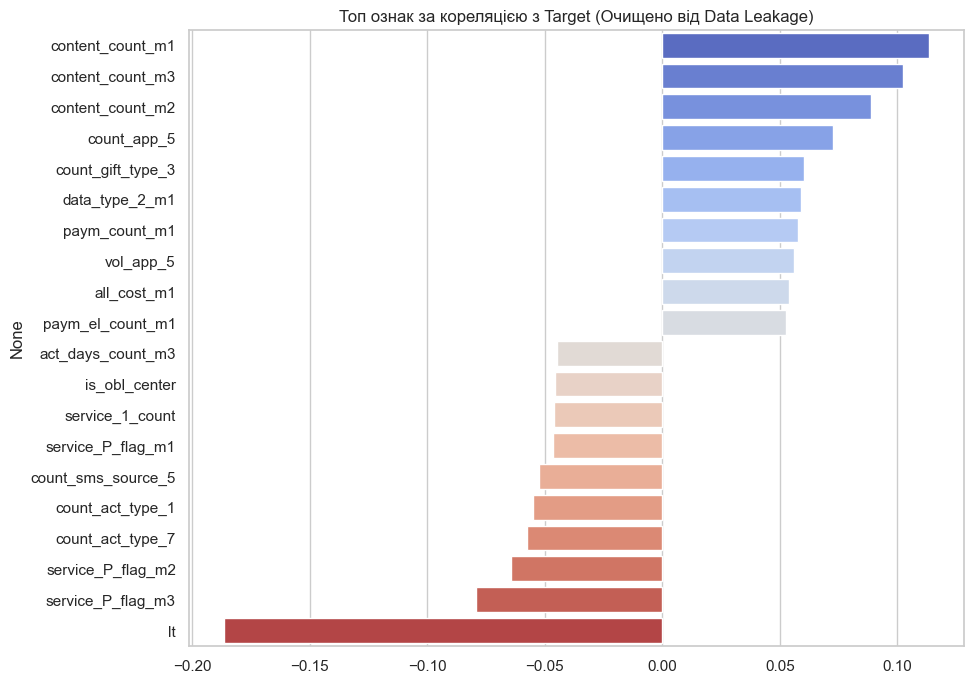

In [9]:
# --- БЛОК 1: Кореляція з таргетом ---
correlations = df.corr()['target'].drop('target').drop('id', errors='ignore').sort_values(ascending=False)

print("Топ-10 позитивних кореляцій:")
print(correlations.head(10))
print("\nТоп-10 негативних кореляцій:")
print(correlations.tail(10))

# Візуалізація
top_features = pd.concat([correlations.head(10), correlations.tail(10)])
plt.figure(figsize=(10, 8))
sns.barplot(x=top_features.values, y=top_features.index, palette="coolwarm")
plt.title("Топ ознак за кореляцією з Target (Очищено від Data Leakage)")
plt.show()

In [10]:
# --- БЛОК 2: Mutual Information та Feature Selection ---
# Використовуємо підвибірку 10k для швидкості
X_sample, _, y_sample, _ = train_test_split(X, y, train_size=10000, stratify=y, random_state=42)

mi_scores = mutual_info_classif(X_sample.fillna(0), y_sample, random_state=42)
mi_scores_series = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)

print("Топ-10 ознак за Mutual Information:")
print(mi_scores_series.head(10))

# Відкидаємо неінформативні ознаки (залишаємо ті, що > 0.001)
features_to_keep = mi_scores_series[mi_scores_series > 0.001].index.tolist()
print(f"\nЗалишено ознак: {len(features_to_keep)} з {X.shape[1]}")

X_filtered = X[features_to_keep]

Топ-10 ознак за Mutual Information:
lt                                0.026614
content_count_m1                  0.013200
content_count_m2                  0.009777
balance_sum                       0.009703
paym_el_count_m3                  0.009353
voice_onnet_in_day_work_dur_m1    0.009350
content_cost_m3                   0.008838
income_brnd_cont_m3               0.008831
income_brnd_cont_m2               0.007978
count_sms_source_5                0.007849
dtype: float64

Залишено ознак: 222 з 440


In [11]:
# --- БЛОК 3: Підготовка даних для моделей ---
# Розбиття на train/val зі збереженням балансу класів
X_train, X_val, y_train, y_val = train_test_split(
    X_filtered, y, test_size=0.2, random_state=42, stratify=y
)

# Масштабування
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

print(f"Train розмір: {X_train.shape}")
print(f"Validation розмір: {X_val.shape}")

Train розмір: (56000, 222)
Validation розмір: (14000, 222)


In [13]:
# --- БЛОК 4: Навчання Baseline моделей ---
results = []

def evaluate(name, model, X_t, y_t, X_v, y_v):
    model.fit(X_t, y_t)
    y_pred = model.predict(X_v)
    y_proba = model.predict_proba(X_v)[:, 1]

    acc = accuracy_score(y_v, y_pred)
    f1 = f1_score(y_v, y_pred)
    roc_auc = roc_auc_score(y_v, y_proba)

    results.append({'Model': name, 'Accuracy': acc, 'F1': f1, 'ROC-AUC': roc_auc})
    return y_proba

# Логістична регресія
lr = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
lr_proba = evaluate('Logistic Regression', lr, X_train_scaled, y_train, X_val_scaled, y_val)

# Random Forest
rf = RandomForestClassifier(n_estimators=100, max_depth=10, class_weight='balanced', n_jobs=-1, random_state=42)
rf_proba = evaluate('Random Forest', rf, X_train, y_train, X_val, y_val)

# LightGBM (11.5 - приблизне співвідношення класів 92/8)
lgbm = lgb.LGBMClassifier(scale_pos_weight=11.5, random_state=42, n_jobs=-1)
lgbm_proba = evaluate('LightGBM', lgbm, X_train, y_train, X_val, y_val)

[LightGBM] [Info] Number of positive: 4241, number of negative: 51759
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070458 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35465
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 218
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.075732 -> initscore=-2.501799
[LightGBM] [Info] Start training from score -2.501799


,Model,Accuracy,F1,ROC-AUC
2,LightGBM,0.794429,0.327884,0.812077
1,Random Forest,0.842000,0.332931,0.803473
0,Logistic Regression,0.719571,0.277778,0.776636


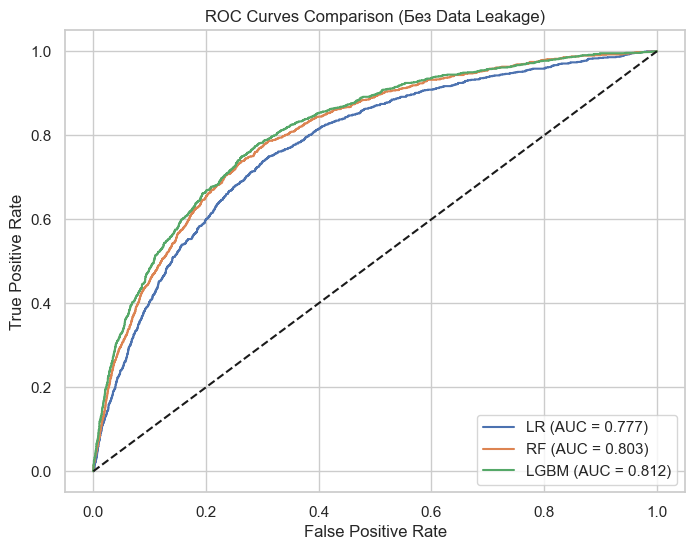

In [14]:
# --- БЛОК 5: Порівняння результатів ---
results_df = pd.DataFrame(results).sort_values(by='ROC-AUC', ascending=False)
display(results_df)

# Побудова ROC-кривих
plt.figure(figsize=(8, 6))
fpr_lr, tpr_lr, _ = roc_curve(y_val, lr_proba)
fpr_rf, tpr_rf, _ = roc_curve(y_val, rf_proba)
fpr_lgb, tpr_lgb, _ = roc_curve(y_val, lgbm_proba)

plt.plot(fpr_lr, tpr_lr, label=f"LR (AUC = {results_df.loc[results_df['Model']=='Logistic Regression', 'ROC-AUC'].values[0]:.3f})")
plt.plot(fpr_rf, tpr_rf, label=f"RF (AUC = {results_df.loc[results_df['Model']=='Random Forest', 'ROC-AUC'].values[0]:.3f})")
plt.plot(fpr_lgb, tpr_lgb, label=f"LGBM (AUC = {results_df.loc[results_df['Model']=='LightGBM', 'ROC-AUC'].values[0]:.3f})")
plt.plot([0, 1], [0, 1], 'k--')

plt.title('ROC Curves Comparison (Без Data Leakage)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()